In [249]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import cross_val_score
from joblib import Parallel, delayed
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
sns.set()
pd.options.display.max_rows = 100

df = pd.read_csv('CR_COST_FC.csv', converters={'PARTY_ID': str, 'COM_ID': str, 'CNTR_SIZE': str})
df['POD'] = pd.to_datetime(df['POD'])
df['ENCODED_TYPE'] = df['ENCODED_TYPE'].fillna(-1).astype(int)
df = df.dropna(subset=['ENCODED_TYPE'])
df['RATE'] = df['RATE'].fillna(-1).astype(int)
df = df.dropna(subset=['RATE'])
df['ENCODED_TYPE'] = df['ENCODED_TYPE'].astype(int)

# Remove NAN values
df_clean= df.dropna().reset_index(drop=True)

df_clean.head()
df_clean.info()
print(f'Dataset size: {df_clean.shape}')

,COM_ID,PARTY_ID,PARTY_ID_EN,PARTY_NAME,CSL_ID,ETA_ETD_NO,ETD_POL_D,POD_ID,POD,CNTR_ID,CNTR_SIZE,CNTR_TYPE,COST_TERM,RATE,ENCODED_TYPE,ENCODED_TERM,POD_ID_EN
0,010,010003678,10003678,OY TAVATUR SHIPPING LTD,ECS010060100191,20060228,FIHEL,HELSINKI,2006-02-28,CTNR010060201232,20,GP,FC,675,2,1,4.103561e+09
1,010,010004286,10004286,"GLOBELINK KOREA CO., LTD",ECS010060100465,20060303,KRPUS,BUSAN,2006-03-03,CTNR010060300014,40,HC,FC,390,1,1,2.904902e+09
2,010,01005136,1005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,ECS010060100321,20060227,NZAKL,AUCKLAND,2006-02-27,CTNR010060201198,40,HC NOR,FC,1615,4,1,2.397848e+09
3,010,01002775,1002775,GLOBELINK INTERNATIONAL PTY LTD-ADELAIDE,ECS010060200201,20060306,AUADL,ADELAIDE,2006-03-06,CTNR010060300119,40,HC,FC,700,1,1,2.480737e+08
4,010,01001088,1001088,CARGO LINES S.A.-LE HAVRE,ECS010060200146,20060307,FRMRS,MARSEILLE,2006-03-07,CTNR010060300185,20,GP,FC,675,2,1,4.197227e+08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54083 entries, 0 to 54082
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   COM_ID        54083 non-null  object        
 1   PARTY_ID      54083 non-null  object        
 2   PARTY_ID_EN   54083 non-null  int64         
 3   PARTY_NAME    54083 non-null  object        
 4   CSL_ID        54083 non-null  object        
 5   ETA_ETD_NO    54083 non-null  int64         
 6   ETD_POL_D     54083 non-null  object        
 7   POD_ID        54083 non-null  object        
 8   POD           54083 non-null  datetime64[ns]
 9   CNTR_ID       54083 non-null  object        
 10  CNTR_SIZE     54083 non-null  object        
 11  CNTR_TYPE     54083 non-null  object        
 12  COST_TERM     54083 non-null  object        
 13  RATE          54083 non-null  int32         
 14  ENCODED_TYPE  54083 non-null  int32         
 15  ENCODED_TERM  54083 non-null  int64 

In [250]:
df_clean['CNTR_SIZE'] = df_clean['CNTR_SIZE'].astype(np.int32)
df_clean['RATE'] = df_clean['RATE'].astype(np.int32)
df_clean['PARTY_ID_EN'] = df_clean['PARTY_ID_EN'].astype(np.int32)
df_clean['POD_ID_EN'] = df_clean['POD_ID_EN'].astype(np.int64)
df_clean['ETA_ETD_NO'] = df_clean['ETA_ETD_NO'].astype(np.int32)
df_clean.info()
df_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54083 entries, 0 to 54082
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   COM_ID        54083 non-null  object        
 1   PARTY_ID      54083 non-null  object        
 2   PARTY_ID_EN   54083 non-null  int32         
 3   PARTY_NAME    54083 non-null  object        
 4   CSL_ID        54083 non-null  object        
 5   ETA_ETD_NO    54083 non-null  int32         
 6   ETD_POL_D     54083 non-null  object        
 7   POD_ID        54083 non-null  object        
 8   POD           54083 non-null  datetime64[ns]
 9   CNTR_ID       54083 non-null  object        
 10  CNTR_SIZE     54083 non-null  int32         
 11  CNTR_TYPE     54083 non-null  object        
 12  COST_TERM     54083 non-null  object        
 13  RATE          54083 non-null  int32         
 14  ENCODED_TYPE  54083 non-null  int32         
 15  ENCODED_TERM  54083 non-null  int64 

,COM_ID,PARTY_ID,PARTY_ID_EN,PARTY_NAME,CSL_ID,ETA_ETD_NO,ETD_POL_D,POD_ID,POD,CNTR_ID,CNTR_SIZE,CNTR_TYPE,COST_TERM,RATE,ENCODED_TYPE,ENCODED_TERM,POD_ID_EN
0,010,010003678,10003678,OY TAVATUR SHIPPING LTD,ECS010060100191,20060228,FIHEL,HELSINKI,2006-02-28,CTNR010060201232,20,GP,FC,675,2,1,4103561210
1,010,010004286,10004286,"GLOBELINK KOREA CO., LTD",ECS010060100465,20060303,KRPUS,BUSAN,2006-03-03,CTNR010060300014,40,HC,FC,390,1,1,2904901796
2,010,01005136,1005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,ECS010060100321,20060227,NZAKL,AUCKLAND,2006-02-27,CTNR010060201198,40,HC NOR,FC,1615,4,1,2397847664
3,010,01002775,1002775,GLOBELINK INTERNATIONAL PTY LTD-ADELAIDE,ECS010060200201,20060306,AUADL,ADELAIDE,2006-03-06,CTNR010060300119,40,HC,FC,700,1,1,248073716
4,010,01001088,1001088,CARGO LINES S.A.-LE HAVRE,ECS010060200146,20060307,FRMRS,MARSEILLE,2006-03-07,CTNR010060300185,20,GP,FC,675,2,1,419722670


In [251]:
sel_col = ['COM_ID','CSL_ID', 'CNTR_ID','ENCODED_TERM','COST_TERM','POD_ID','ETD_POL_D','PARTY_ID',
           'PARTY_ID_EN', 'PARTY_NAME','POD_ID_EN','ETA_ETD_NO','POD',
           'CNTR_SIZE','ENCODED_TYPE','CNTR_TYPE','RATE']

df_fc = df_clean[sel_col]
df_fc.head()
df_fc.info()

,COM_ID,CSL_ID,CNTR_ID,ENCODED_TERM,COST_TERM,POD_ID,ETD_POL_D,PARTY_ID,PARTY_ID_EN,PARTY_NAME,POD_ID_EN,ETA_ETD_NO,POD,CNTR_SIZE,ENCODED_TYPE,CNTR_TYPE,RATE
0,010,ECS010060100191,CTNR010060201232,1,FC,HELSINKI,FIHEL,010003678,10003678,OY TAVATUR SHIPPING LTD,4103561210,20060228,2006-02-28,20,2,GP,675
1,010,ECS010060100465,CTNR010060300014,1,FC,BUSAN,KRPUS,010004286,10004286,"GLOBELINK KOREA CO., LTD",2904901796,20060303,2006-03-03,40,1,HC,390
2,010,ECS010060100321,CTNR010060201198,1,FC,AUCKLAND,NZAKL,01005136,1005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2397847664,20060227,2006-02-27,40,4,HC NOR,1615
3,010,ECS010060200201,CTNR010060300119,1,FC,ADELAIDE,AUADL,01002775,1002775,GLOBELINK INTERNATIONAL PTY LTD-ADELAIDE,248073716,20060306,2006-03-06,40,1,HC,700
4,010,ECS010060200146,CTNR010060300185,1,FC,MARSEILLE,FRMRS,01001088,1001088,CARGO LINES S.A.-LE HAVRE,419722670,20060307,2006-03-07,20,2,GP,675


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54083 entries, 0 to 54082
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   COM_ID        54083 non-null  object        
 1   CSL_ID        54083 non-null  object        
 2   CNTR_ID       54083 non-null  object        
 3   ENCODED_TERM  54083 non-null  int64         
 4   COST_TERM     54083 non-null  object        
 5   POD_ID        54083 non-null  object        
 6   ETD_POL_D     54083 non-null  object        
 7   PARTY_ID      54083 non-null  object        
 8   PARTY_ID_EN   54083 non-null  int32         
 9   PARTY_NAME    54083 non-null  object        
 10  POD_ID_EN     54083 non-null  int64         
 11  ETA_ETD_NO    54083 non-null  int32         
 12  POD           54083 non-null  datetime64[ns]
 13  CNTR_SIZE     54083 non-null  int32         
 14  ENCODED_TYPE  54083 non-null  int32         
 15  CNTR_TYPE     54083 non-null  object

In [252]:
# filter out rows where the year is 2002
df_filtered = df_fc[df_fc['POD'].dt.year != 2002]
df_filtered.head()
df_filtered.info()

# Checking if year 2002 is removed
df_filtered['POD'].dt.year.unique()

,COM_ID,CSL_ID,CNTR_ID,ENCODED_TERM,COST_TERM,POD_ID,ETD_POL_D,PARTY_ID,PARTY_ID_EN,PARTY_NAME,POD_ID_EN,ETA_ETD_NO,POD,CNTR_SIZE,ENCODED_TYPE,CNTR_TYPE,RATE
0,010,ECS010060100191,CTNR010060201232,1,FC,HELSINKI,FIHEL,010003678,10003678,OY TAVATUR SHIPPING LTD,4103561210,20060228,2006-02-28,20,2,GP,675
1,010,ECS010060100465,CTNR010060300014,1,FC,BUSAN,KRPUS,010004286,10004286,"GLOBELINK KOREA CO., LTD",2904901796,20060303,2006-03-03,40,1,HC,390
2,010,ECS010060100321,CTNR010060201198,1,FC,AUCKLAND,NZAKL,01005136,1005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2397847664,20060227,2006-02-27,40,4,HC NOR,1615
3,010,ECS010060200201,CTNR010060300119,1,FC,ADELAIDE,AUADL,01002775,1002775,GLOBELINK INTERNATIONAL PTY LTD-ADELAIDE,248073716,20060306,2006-03-06,40,1,HC,700
4,010,ECS010060200146,CTNR010060300185,1,FC,MARSEILLE,FRMRS,01001088,1001088,CARGO LINES S.A.-LE HAVRE,419722670,20060307,2006-03-07,20,2,GP,675


<class 'pandas.core.frame.DataFrame'>
Int64Index: 54082 entries, 0 to 54082
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   COM_ID        54082 non-null  object        
 1   CSL_ID        54082 non-null  object        
 2   CNTR_ID       54082 non-null  object        
 3   ENCODED_TERM  54082 non-null  int64         
 4   COST_TERM     54082 non-null  object        
 5   POD_ID        54082 non-null  object        
 6   ETD_POL_D     54082 non-null  object        
 7   PARTY_ID      54082 non-null  object        
 8   PARTY_ID_EN   54082 non-null  int32         
 9   PARTY_NAME    54082 non-null  object        
 10  POD_ID_EN     54082 non-null  int64         
 11  ETA_ETD_NO    54082 non-null  int32         
 12  POD           54082 non-null  datetime64[ns]
 13  CNTR_SIZE     54082 non-null  int32         
 14  ENCODED_TYPE  54082 non-null  int32         
 15  CNTR_TYPE     54082 non-null  object

array([2006, 2005, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2018, 2019, 2020, 2021, 2016, 2017, 2022, 2023], dtype=int64)

In [253]:
df_filtered = df_filtered.drop_duplicates(subset=['POD']).reset_index(drop=True)
df_filtered.info()
df_filtered.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6339 entries, 0 to 6338
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   COM_ID        6339 non-null   object        
 1   CSL_ID        6339 non-null   object        
 2   CNTR_ID       6339 non-null   object        
 3   ENCODED_TERM  6339 non-null   int64         
 4   COST_TERM     6339 non-null   object        
 5   POD_ID        6339 non-null   object        
 6   ETD_POL_D     6339 non-null   object        
 7   PARTY_ID      6339 non-null   object        
 8   PARTY_ID_EN   6339 non-null   int32         
 9   PARTY_NAME    6339 non-null   object        
 10  POD_ID_EN     6339 non-null   int64         
 11  ETA_ETD_NO    6339 non-null   int32         
 12  POD           6339 non-null   datetime64[ns]
 13  CNTR_SIZE     6339 non-null   int32         
 14  ENCODED_TYPE  6339 non-null   int32         
 15  CNTR_TYPE     6339 non-null   object  

,COM_ID,CSL_ID,CNTR_ID,ENCODED_TERM,COST_TERM,POD_ID,ETD_POL_D,PARTY_ID,PARTY_ID_EN,PARTY_NAME,POD_ID_EN,ETA_ETD_NO,POD,CNTR_SIZE,ENCODED_TYPE,CNTR_TYPE,RATE
0,010,ECS010060100191,CTNR010060201232,1,FC,HELSINKI,FIHEL,010003678,10003678,OY TAVATUR SHIPPING LTD,4103561210,20060228,2006-02-28,20,2,GP,675
1,010,ECS010060100465,CTNR010060300014,1,FC,BUSAN,KRPUS,010004286,10004286,"GLOBELINK KOREA CO., LTD",2904901796,20060303,2006-03-03,40,1,HC,390
2,010,ECS010060100321,CTNR010060201198,1,FC,AUCKLAND,NZAKL,01005136,1005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2397847664,20060227,2006-02-27,40,4,HC NOR,1615
3,010,ECS010060200201,CTNR010060300119,1,FC,ADELAIDE,AUADL,01002775,1002775,GLOBELINK INTERNATIONAL PTY LTD-ADELAIDE,248073716,20060306,2006-03-06,40,1,HC,700
4,010,ECS010060200146,CTNR010060300185,1,FC,MARSEILLE,FRMRS,01001088,1001088,CARGO LINES S.A.-LE HAVRE,419722670,20060307,2006-03-07,20,2,GP,675


In [254]:
df_filtered = df_filtered.sort_values(by='POD').reset_index(drop=True)
df_filtered.head()
df_filtered['POD'].dt.year.unique()

,COM_ID,CSL_ID,CNTR_ID,ENCODED_TERM,COST_TERM,POD_ID,ETD_POL_D,PARTY_ID,PARTY_ID_EN,PARTY_NAME,POD_ID_EN,ETA_ETD_NO,POD,CNTR_SIZE,ENCODED_TYPE,CNTR_TYPE,RATE
0,010,ECS01050600224,CTNR010050700354,1,FC,ROTTERDAM,NLRTM,01008827,1008827,YANG MING (SINGAPORE) PTE. LTD.,3241651053,20050715,2005-07-15,40,4,HC NOR,1620
1,010,ECS01050600325,CTNR010050700379,1,FC,BUSAN,KRPUS,01001867,1001867,DONGSUE CONSOLIDATION COMPANY LTD,2904901796,20050716,2005-07-16,20,2,GP,220
2,010,ECS010050700025,CTNR010050700537,1,FC,HOCHIMINH CITY ( TAN CANG ),VNSGN,01004649,1004649,M & P INTERNATIONAL CO LTD-HO CHI MINH,2072622400,20050717,2005-07-17,40,1,HC,430
3,010,ECS010050700069,CTNR010050700490,1,FC,PENANG,MYPEN,01002765,1002765,GLOBELINK CONTAINER LINES (JB) S/B-PENANG,1704724096,20050718,2005-07-18,20,2,GP,50
4,010,ECS01050600309,CTNR010050700545,1,FC,HONG KONG,HKHKG,01004594,1004594,LONGROW SHIPPING LTD,4080053569,20050719,2005-07-19,40,1,HC,150


array([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023], dtype=int64)

<h4>FIltering and getting a list stored as a dictionary</h4>

In [255]:
def filter_dataframe(df):
    filtered_dataframes = {}

    for (port, size, ctype, party_id), group in df.groupby(['POD_ID', 'CNTR_SIZE', 'CNTR_TYPE', 'PARTY_ID']):
        group = group.reset_index(drop=True).sort_values(by='POD')
        df_id = f"Port_{port}_Size_{size}_Type_{ctype}_PartyID_{party_id}"
        filtered_dataframes[df_id] = group

    return filtered_dataframes

In [256]:
filtered_dataframes = filter_dataframe(df_filtered)

In [257]:
df_ids = list(filtered_dataframes.keys())
print(list(df_ids))
print(len(list(df_ids)))

['Port_AARHUS_Size_20_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_20_Type_GP_PartyID_0100027830', 'Port_AARHUS_Size_20_Type_GP_PartyID_010006666', 'Port_AARHUS_Size_40_Type_HC_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100027830', 'Port_AARHUS_Size_40_Type_HC_PartyID_010006666', 'Port_ADELAIDE_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC NOR_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_40_Type_HC_PartyID_01002775', 'Port_ALEXANDRIA (EL DEKHELA PORT)_Size_40_Type_HC_PartyID_010004995', 'Port_ALEXANDRIA (OLD PORT)_Size_20_Type_GP_PartyID_010004995', 'Port_ALEXANDRIA (OLD PORT)_Size_40_Type_HC_PartyID_010004995', 'Port_ALEXANDRIA(OLD PORT)_Size_20_Type_GP_PartyID_010004995', 'Port_ALEXANDRIA(OLD PORT)_Size_40_Type_HC_PartyID_010004995', 'Port_ALGECIRAS_Size_20_Type_GP_PartyID_01008306', 'Port_ALGECIRAS_Size_40_Type_HC_PartyID_01008306', 'Port_ALGECIRAS_

For testing

In [258]:
# filtered_dataframes = filter_dataframe(df)
# top_3_keys = list(filtered_dataframes.keys())[:3]
# filtered_dataframes_subset = {key: filtered_dataframes[key] for key in top_3_keys}
# print(len(filtered_dataframes_subset))


In [259]:
# Get a dictionary with key and number of rows for each dataframe in filtered_dataframes
key_row_counts = {key: len(filtered_dataframes[key]) for key in filtered_dataframes}

# Sort the key_row_counts dictionary by value (number of rows) in descending order
sorted_key_row_counts = sorted(key_row_counts.items(), key=lambda item: item[1], reverse=True)
print(sorted_key_row_counts)

# Get the top 5 keys with the most rows
top_5_keys_tuple = sorted_key_row_counts[:5]
print(top_5_keys_tuple)

# Create a dictionary with the top 5 keys and their corresponding dataframes (with up to 5 rows per dataframe)
filtered_dataframes_subset = {}

for key, row_count in top_5_keys_tuple:
    filtered_dataframes_subset[key] = filtered_dataframes[key][:5]
    print(f"Number of rows in {key}: {row_count}")

print(filtered_dataframes_subset.keys())

[('Port_BUSAN_Size_40_Type_HC_PartyID_010004286', 196), ('Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136', 179), ('Port_SYDNEY_Size_40_Type_HC_PartyID_01002779', 171), ('Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778', 151), ('Port_AUCKLAND_Size_40_Type_HC NOR_PartyID_01005136', 122), ('Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788', 118), ('Port_HOCHIMINH CAT LAI,VIETNAM_Size_40_Type_HC_PartyID_010005256', 107), ('Port_BRISBANE_Size_40_Type_HC_PartyID_01002776', 105), ('Port_MANILA (NORTH HARBOUR)_Size_40_Type_HC_PartyID_01004969', 93), ('Port_PORT LOUIS_Size_40_Type_HC_PartyID_010007778', 93), ('Port_FREMANTLE_Size_40_Type_HC_PartyID_01002777', 91), ('Port_MANILA (NORTH HARBOUR)_Size_40_Type_HC_PartyID_010021727', 76), ('Port_NHAVA SHEVA_Size_40_Type_HC_PartyID_01002787', 73), ('Port_CAT LAI (HO CHI MINH)_Size_40_Type_HC_PartyID_010005256', 69), ('Port_LIMASSOL_Size_40_Type_HC_PartyID_010007769', 69), ('Port_HAIPHONG_Size_40_Type_HC_PartyID_010005255', 65), ('Port_BANGKOK_

Testing key

In [260]:
# grouped_df = filtered_dataframes['Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136']
# grouped_df.head()
# grouped_df.info()

In [261]:
# Selected dataframe
sel_df = filtered_dataframes['Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136']
sel_df.head()
sel_df.info()

,COM_ID,CSL_ID,CNTR_ID,ENCODED_TERM,COST_TERM,POD_ID,ETD_POL_D,PARTY_ID,PARTY_ID_EN,PARTY_NAME,POD_ID_EN,ETA_ETD_NO,POD,CNTR_SIZE,ENCODED_TYPE,CNTR_TYPE,RATE
0,010,ECS010050700037,CTNR010050700657,1,FC,AUCKLAND,NZAKL,01005136,1005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2397847664,20050721,2005-07-21,40,1,HC,2300
1,010,ECS01050600042,CTNR010050700971,1,FC,AUCKLAND,NZAKL,01005136,1005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2397847664,20050729,2005-07-29,40,1,HC,2600
2,010,ECS010050700465,CTNR010050800578,1,FC,AUCKLAND,NZAKL,01005136,1005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2397847664,20050815,2005-08-15,40,1,HC,2200
3,010,ECS010051000263,CTNR010051001440,1,FC,AUCKLAND,NZAKL,01005136,1005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2397847664,20051105,2005-11-05,40,1,HC,2200
4,010,ECS010051100412,CTNR010051101566,1,FC,AUCKLAND,NZAKL,01005136,1005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2397847664,20051208,2005-12-08,40,1,HC,2200


<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 0 to 178
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   COM_ID        179 non-null    object        
 1   CSL_ID        179 non-null    object        
 2   CNTR_ID       179 non-null    object        
 3   ENCODED_TERM  179 non-null    int64         
 4   COST_TERM     179 non-null    object        
 5   POD_ID        179 non-null    object        
 6   ETD_POL_D     179 non-null    object        
 7   PARTY_ID      179 non-null    object        
 8   PARTY_ID_EN   179 non-null    int32         
 9   PARTY_NAME    179 non-null    object        
 10  POD_ID_EN     179 non-null    int64         
 11  ETA_ETD_NO    179 non-null    int32         
 12  POD           179 non-null    datetime64[ns]
 13  CNTR_SIZE     179 non-null    int32         
 14  ENCODED_TYPE  179 non-null    int32         
 15  CNTR_TYPE     179 non-null    object    

<h4>Training Isolation Forest with all historical data for anomaly</h4>

In [262]:
def annomly_iso(filtered_dataframes_subset):

    # Initialize a dictionary to store the trained models and their evaluation scores
    trained_models = {}
    scores = {}

    # Train an IsolationForest model on each dataframe and evaluate its performance using cross-validation
    for key, group in filtered_dataframes_subset.items():
        print(key)
        
        # Create an IsolationForest model
        model = IsolationForest(n_estimators=100, contamination='auto', max_samples='auto', random_state=42)

        # Evaluate the model using cross-validation
        n_splits = max(min([len(group)-1 for group in filtered_dataframes_subset.values()]), 2)
        if n_splits == 0:
            scores[key] = 0
            continue
        score = cross_val_score(model, group[['RATE']], cv=n_splits, scoring='roc_auc').mean()
        print(score)
        scores[key] = score

        # Fit the model to the dataframe
        model.fit(group[['RATE']])

        # Store the trained model
        trained_models[key] = model

    # Select the model with the highest evaluation score
    best_model_key = max(scores, key=scores.get)
    best_model = trained_models[best_model_key]
    print(best_model_key)

    # Return the best model
    return best_model_key, best_model

Cross-validation can be used for evaluating the performance of an Isolation Forest algorithm for anomaly detection, but it's not always the best option.

Isolation Forest is an unsupervised learning algorithm, which means that there are no labels available to evaluate its performance in a traditional supervised learning sense. In this case, cross-validation can be used to evaluate the stability of the algorithm and its ability to detect anomalies in new, unseen data.

However, cross-validation assumes that the data is independently and identically distributed (i.i.d.), which may not always be the case in practice, especially when dealing with time series data. In such cases, a more appropriate evaluation method may be to use a sliding window approach, where the model is trained on a fixed window of past data and evaluated on a sliding window of future data.

Another evaluation metric that can be used for Isolation Forest is the area under the Receiver Operating Characteristic (ROC) curve (AUC-ROC). AUC-ROC is a measure of how well the model can distinguish between normal and anomalous data points, and can be useful when evaluating the performance of anomaly detection algorithms.

In summary, while cross-validation can be useful for evaluating the performance of an Isolation Forest algorithm, it's not always the best option, and other evaluation metrics and methods should also be considered depending on the specific use case and data characteristics.

In [263]:
best_model_key, best_model = annomly_iso(filtered_dataframes_subset)

Port_BUSAN_Size_40_Type_HC_PartyID_010004286


c:\Users\it1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\it1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
TypeError: _ThresholdScorer._score() missing 1 required positional argument: 'y'

  warnings.warn(
c:\Users\it1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\it1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_cal

nan
Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136


c:\Users\it1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\it1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
TypeError: _ThresholdScorer._score() missing 1 required positional argument: 'y'

  warnings.warn(
c:\Users\it1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\it1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_cal

nan
Port_SYDNEY_Size_40_Type_HC_PartyID_01002779


c:\Users\it1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\it1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
TypeError: _ThresholdScorer._score() missing 1 required positional argument: 'y'

  warnings.warn(
c:\Users\it1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\it1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_cal

nan
Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778


c:\Users\it1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\it1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
TypeError: _ThresholdScorer._score() missing 1 required positional argument: 'y'

  warnings.warn(
c:\Users\it1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\it1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_cal

nan
Port_AUCKLAND_Size_40_Type_HC NOR_PartyID_01005136


c:\Users\it1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\it1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
TypeError: _ThresholdScorer._score() missing 1 required positional argument: 'y'

  warnings.warn(
c:\Users\it1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\it1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_cal

nan
Port_BUSAN_Size_40_Type_HC_PartyID_010004286


In [264]:
print(best_model_key)
df_best_key = filtered_dataframes[best_model_key]
df_best_key.head()
df_best_key.info()

Port_BUSAN_Size_40_Type_HC_PartyID_010004286


,COM_ID,CSL_ID,CNTR_ID,ENCODED_TERM,COST_TERM,POD_ID,ETD_POL_D,PARTY_ID,PARTY_ID_EN,PARTY_NAME,POD_ID_EN,ETA_ETD_NO,POD,CNTR_SIZE,ENCODED_TYPE,CNTR_TYPE,RATE
0,010,ECS010050800407,CTNR010050901151,1,FC,BUSAN,KRPUS,010004286,10004286,"GLOBELINK KOREA CO., LTD",2904901796,20051003,2005-10-03,40,1,HC,390
1,010,ECS010050900468,CTNR010050901461,1,FC,BUSAN,KRPUS,010004286,10004286,"GLOBELINK KOREA CO., LTD",2904901796,20051007,2005-10-07,40,1,HC,390
2,010,ECS010051000382,CTNR010051101339,1,FC,BUSAN,KRPUS,010004286,10004286,"GLOBELINK KOREA CO., LTD",2904901796,20051128,2005-11-28,40,1,HC,390
3,010,ECS010051100224,CTNR010051200319,1,FC,BUSAN,KRPUS,010004286,10004286,"GLOBELINK KOREA CO., LTD",2904901796,20051210,2005-12-10,40,1,HC,390
4,010,ECS010051200414,CTNR010051201185,1,FC,BUSAN,KRPUS,010004286,10004286,"GLOBELINK KOREA CO., LTD",2904901796,20060107,2006-01-07,40,1,HC,390


<class 'pandas.core.frame.DataFrame'>
Int64Index: 196 entries, 0 to 195
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   COM_ID        196 non-null    object        
 1   CSL_ID        196 non-null    object        
 2   CNTR_ID       196 non-null    object        
 3   ENCODED_TERM  196 non-null    int64         
 4   COST_TERM     196 non-null    object        
 5   POD_ID        196 non-null    object        
 6   ETD_POL_D     196 non-null    object        
 7   PARTY_ID      196 non-null    object        
 8   PARTY_ID_EN   196 non-null    int32         
 9   PARTY_NAME    196 non-null    object        
 10  POD_ID_EN     196 non-null    int64         
 11  ETA_ETD_NO    196 non-null    int32         
 12  POD           196 non-null    datetime64[ns]
 13  CNTR_SIZE     196 non-null    int32         
 14  ENCODED_TYPE  196 non-null    int32         
 15  CNTR_TYPE     196 non-null    object    

IsolationForest(random_state=42)

,COM_ID,CSL_ID,CNTR_ID,ENCODED_TERM,COST_TERM,POD_ID,ETD_POL_D,PARTY_ID,PARTY_ID_EN,PARTY_NAME,POD_ID_EN,ETA_ETD_NO,POD,CNTR_SIZE,ENCODED_TYPE,CNTR_TYPE,RATE,ANOMALY
0,010,ECS010050800407,CTNR010050901151,1,FC,BUSAN,KRPUS,010004286,10004286,"GLOBELINK KOREA CO., LTD",2904901796,20051003,2005-10-03,40,1,HC,390,-1
1,010,ECS010050900468,CTNR010050901461,1,FC,BUSAN,KRPUS,010004286,10004286,"GLOBELINK KOREA CO., LTD",2904901796,20051007,2005-10-07,40,1,HC,390,-1
2,010,ECS010051000382,CTNR010051101339,1,FC,BUSAN,KRPUS,010004286,10004286,"GLOBELINK KOREA CO., LTD",2904901796,20051128,2005-11-28,40,1,HC,390,-1
3,010,ECS010051100224,CTNR010051200319,1,FC,BUSAN,KRPUS,010004286,10004286,"GLOBELINK KOREA CO., LTD",2904901796,20051210,2005-12-10,40,1,HC,390,-1
4,010,ECS010051200414,CTNR010051201185,1,FC,BUSAN,KRPUS,010004286,10004286,"GLOBELINK KOREA CO., LTD",2904901796,20060107,2006-01-07,40,1,HC,390,-1


Text(0.5, 0, 'Date')

Text(0, 0.5, 'Rate')

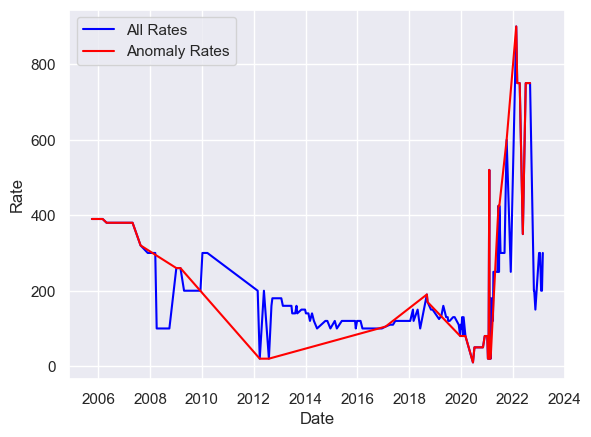

In [265]:
# Train the algorithm
best_model.fit(df_best_key[['RATE']])

# Predict anomalies
df_best_key['ANOMALY'] = best_model.predict(df_best_key[['RATE']])
# df_best_key.head()

# Create a new dataframe for the anomalies
is_anomaly = df_best_key[df_best_key['ANOMALY']== -1].reset_index(drop=True)
is_anomaly.head()

# Plot the data
plt.plot(df_best_key['POD'], df_best_key['RATE'],
         color='blue', label='All Rates')
plt.plot(is_anomaly['POD'], is_anomaly['RATE'],
         color='red', label='Anomaly Rates')

# Add axis labels and legend
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()

# Show the plot
plt.show()

# # Print values
# print(df)
# print(is_anomaly)